In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
#from sklearn.preprocessing import OneHotEncoder


tf.__version__

2023-05-26 11:50:34.665579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 11:50:34.785858: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-26 11:50:35.256162: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-26 11:50:35.256229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
csv_file = '../Dataset/dataset.csv'
#csv_file = '../Dataset/dataset_augmented.csv'
#csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,484.4822,350.23
1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,2,774.6917,347.50
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,4,644.6140,364.11
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,2,630.3364,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,392.8587,358.78


In [3]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822
1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,774.6917
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,644.6140
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,630.3364
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587


1
32
140
83
77


Text(0, 0.5, 'count')

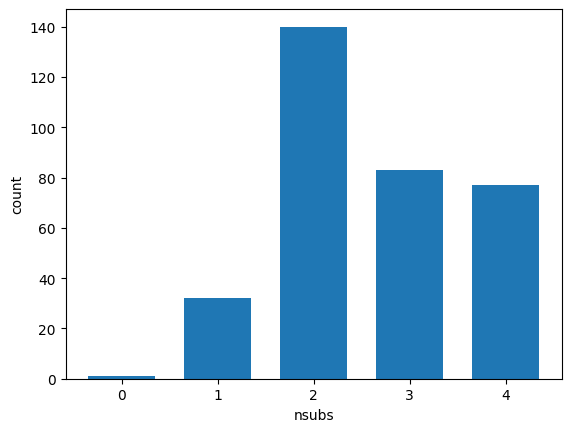

In [4]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)
plt.xlabel('nsubs')
plt.ylabel('count')

In [5]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,333.0,0.345345,0.936678,0.0000,0.0000,0.0000,0.0000,4.0000
Pos2,333.0,0.444444,1.081362,0.0000,0.0000,0.0000,0.0000,4.0000
Pos3,333.0,0.369369,0.978023,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,333.0,0.426426,1.040516,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,333.0,0.429429,1.037826,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,333.0,0.363363,0.961664,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,333.0,0.366366,0.955806,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,333.0,0.450450,1.084436,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,333.0,0.483483,1.104699,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,333.0,0.435435,1.075272,0.0000,0.0000,0.0000,0.0000,4.0000


/tmp/ipykernel_74231/2418938743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe[['target']])


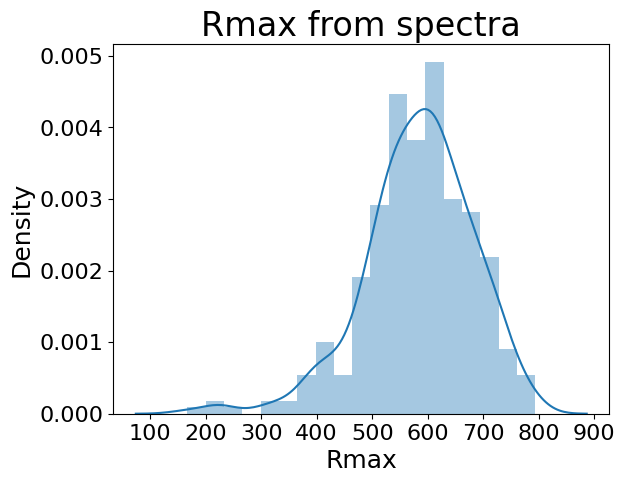

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

#sns.pairplot(dataframe[['target']], diag_kind='kde')
#sns.set_style('darkgrid')
sns.distplot(dataframe[['target']])
plt.title('Rmax from spectra',fontsize=24)
plt.xlabel('Rmax',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Text(0, 0.5, 'Rmax')

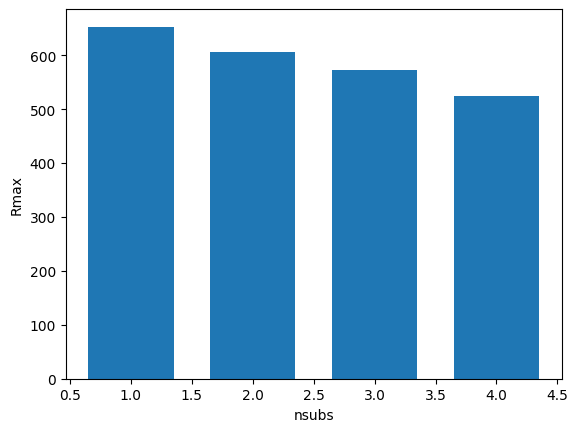

In [7]:
# Rmax as a function of nsubs
Rmax = []
Rmax[:] = dataframe['target']

nsubs1 = [i for i in range(len(nsubs)) if nsubs[i]==1]
nsubs2 = [i for i in range(len(nsubs)) if nsubs[i]==2]
nsubs3 = [i for i in range(len(nsubs)) if nsubs[i]==3]
nsubs4 = [i for i in range(len(nsubs)) if nsubs[i]==4]

Rmax1 = [Rmax[i] for i in nsubs1]
Rmax2 = [Rmax[i] for i in nsubs2]
Rmax3 = [Rmax[i] for i in nsubs3]
Rmax4 = [Rmax[i] for i in nsubs4]

Rmax1_mean = np.mean(Rmax1)
Rmax2_mean = np.mean(Rmax2)
Rmax3_mean = np.mean(Rmax3)
Rmax4_mean = np.mean(Rmax4)

Rmax_mean = [Rmax1_mean, Rmax2_mean, Rmax3_mean, Rmax4_mean]

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([1,2,3,4],Rmax_mean, width=0.7)
plt.xlabel('nsubs')
plt.ylabel('Rmax')


In [8]:
# remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose()

# remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose())

        count        mean        std       min         25%        50%  \
Pos1    324.0    0.333333   0.931060    0.0000    0.000000    0.00000   
Pos2    324.0    0.416667   1.039096    0.0000    0.000000    0.00000   
Pos3    324.0    0.351852   0.953872    0.0000    0.000000    0.00000   
Pos4    324.0    0.404321   1.004686    0.0000    0.000000    0.00000   
Pos5    324.0    0.429012   1.031046    0.0000    0.000000    0.00000   
Pos6    324.0    0.361111   0.952022    0.0000    0.000000    0.00000   
Pos7    324.0    0.376543   0.967045    0.0000    0.000000    0.00000   
Pos8    324.0    0.453704   1.087938    0.0000    0.000000    0.00000   
Pos9    324.0    0.490741   1.114181    0.0000    0.000000    0.00000   
Pos10   324.0    0.435185   1.069763    0.0000    0.000000    0.00000   
Pos11   324.0    0.364198   0.968585    0.0000    0.000000    0.00000   
Pos12   324.0    0.398148   1.031454    0.0000    0.000000    0.00000   
Pos13   324.0    0.256173   0.821042    0.0000    0

In [9]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,324.0,3.333333e-01,0.931060,0.000000,0.000000,0.00000,0.00000,4.000000
Pos2,324.0,4.166667e-01,1.039096,0.000000,0.000000,0.00000,0.00000,4.000000
Pos3,324.0,3.518519e-01,0.953872,0.000000,0.000000,0.00000,0.00000,4.000000
Pos4,324.0,4.043210e-01,1.004686,0.000000,0.000000,0.00000,0.00000,4.000000
Pos5,324.0,4.290123e-01,1.031046,0.000000,0.000000,0.00000,0.00000,4.000000
Pos6,324.0,3.611111e-01,0.952022,0.000000,0.000000,0.00000,0.00000,4.000000
Pos7,324.0,3.765432e-01,0.967045,0.000000,0.000000,0.00000,0.00000,4.000000
Pos8,324.0,4.537037e-01,1.087938,0.000000,0.000000,0.00000,0.00000,4.000000
Pos9,324.0,4.907407e-01,1.114181,0.000000,0.000000,0.00000,0.00000,4.000000
Pos10,324.0,4.351852e-01,1.069763,0.000000,0.000000,0.00000,0.00000,4.000000


In [10]:
# One-hot encode inpute features manually 
n_data = dataset.shape[0]
n_atom_types = 5   # (H,Fl,Cl,Br,I)
n_pos = 16         # 6-helicenes have 16 possible positions to be occupied
n_features = int(n_atom_types*n_pos)
x_data = np.zeros( (n_data, n_features) )
y_data = np.zeros(n_data)

n_labels = 1
data = np.zeros( (n_data, n_features+n_labels) )

dataset_np = dataset.to_numpy()
#print(dataset_np.shape)
for i in range(n_data):
    for j in range(n_pos):
        atom_id = int(dataset_np[i,j])
        x_data[i,j*n_atom_types+atom_id] = 1.0

    #print(x_data[i,:])
    #print(dataset_np[i,:16])

    y_data[i] = dataset_np[i,n_pos]

    data[i,0:n_features] = x_data[i,:] 
    data[i,n_features] = y_data[i]

print(x_data.shape)
print(y_data.shape)
print(data.shape)


(324, 80)
(324,)
(324, 81)


In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#x_data = data[:,0:n_features]
#y_data = data[:,n_features]
data = shuffle(data, random_state=39)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print(len(x_train), 'training examples')
print(len(x_test), 'test and validation examples')
print(x_train.shape)
print(y_train.shape)

259 training examples
65 test and validation examples
(259, 80)
(259,)


In [42]:
# Single non-linear model with multiple inputs

# save into a list inputs for different positions
global_inputs = []
for i in range(n_pos):
    input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_'+str(i+1) )
    global_inputs.append( input_i )
print(global_inputs)

# Define the architecture of a common model giving an atomic coefficient depending on the element
def atomic_coef_model():
    inputs = tf.keras.Input( shape=(n_atom_types,) )
    output = tf.keras.layers.Dense(1,use_bias=False,kernel_initializer='random_normal')(inputs)
    return tf.keras.Model(inputs,output)

# Build atomic coefficient model
atom_coef_model = atomic_coef_model()

# Apply element_model to each position
atom_coef_outputs = []
for i in range(n_pos):
    output_i = atom_coef_model( global_inputs[i] )
    atom_coef_outputs.append( output_i )
print(atom_coef_outputs)

# Define the architecture of the many body neural network model
def NN_model():
    inputs = tf.keras.Input( shape=(n_pos,) )
    #output = tf.keras.layers.Dense(units=256, activation='relu',kernel_initializer='random_normal',bias_initializer='zeros')(inputs)
    output = tf.keras.layers.Dense(units=64, activation='relu',kernel_initializer='random_normal',bias_initializer='zeros')(inputs)
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(units=64, activation='relu',kernel_initializer='random_normal',bias_initializer='zeros')(inputs)
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(units=64, activation='relu',kernel_initializer='random_normal',bias_initializer='zeros')(inputs)
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(units=64, activation='relu',kernel_initializer='random_normal',bias_initializer='zeros')(inputs)
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(1)(output)
    return tf.keras.Model(inputs,output)

manybody_NN = NN_model()

# Input of NN models in the vector composed by the atomic coefficients
atom_coef_outputs_rev = []
for i in range(n_pos):
    atom_coef_outputs_rev.append( atom_coef_outputs[n_pos-i-1] )

atom_coeffs = tf.keras.layers.Concatenate()(atom_coef_outputs)
atom_coeffs_rev = tf.keras.layers.Concatenate()(atom_coef_outputs_rev)
global_output = manybody_NN(atom_coeffs) + manybody_NN(atom_coeffs_rev)

model = tf.keras.Model(inputs=global_inputs,outputs=global_output)

model.summary()
tf.keras.utils.plot_model(model, "non-linear_invariant_model_simple.png", show_shapes=True)

learning_rate = 0.01
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error')

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_1')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_2')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_3')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_4')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_5')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_6')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_7')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_8')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_9')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_10')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_11')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_12')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_13')>, <KerasTensor: shape=(None, 5) dtype=float32 (c

In [43]:
# Train single model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=40, min_lr=1e-6)
                              #patience=10, min_lr=1e-6)

#epochs = 200
epochs = 600
batch_size = 4

# split input into 16 positions
train_inputs = np.split(x_train,n_pos,axis=1)
print(len(train_inputs))
#history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
#model = tuner.hypermodel.build(best_hps)
tf.keras.utils.plot_model(model, "non-linear_many-body_invariant_model.png", show_shapes=True)
history = model.fit(x=train_inputs, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)


16
Epoch 1/600
59/59 - 1s - loss: 0.8211 - val_loss: 0.7746 - lr: 0.0100 - 599ms/epoch - 10ms/step
Epoch 2/600
59/59 - 0s - loss: 0.8134 - val_loss: 0.7458 - lr: 0.0100 - 96ms/epoch - 2ms/step
Epoch 3/600
59/59 - 0s - loss: 0.5859 - val_loss: 0.8448 - lr: 0.0100 - 85ms/epoch - 1ms/step
Epoch 4/600
59/59 - 0s - loss: 0.5426 - val_loss: 0.4445 - lr: 0.0100 - 75ms/epoch - 1ms/step
Epoch 5/600
59/59 - 0s - loss: 0.4843 - val_loss: 0.4694 - lr: 0.0100 - 80ms/epoch - 1ms/step
Epoch 6/600
59/59 - 0s - loss: 0.4780 - val_loss: 0.3977 - lr: 0.0100 - 78ms/epoch - 1ms/step
Epoch 7/600
59/59 - 0s - loss: 0.4343 - val_loss: 0.4327 - lr: 0.0100 - 81ms/epoch - 1ms/step
Epoch 8/600
59/59 - 0s - loss: 0.4736 - val_loss: 0.4383 - lr: 0.0100 - 78ms/epoch - 1ms/step
Epoch 9/600
59/59 - 0s - loss: 0.4313 - val_loss: 0.4082 - lr: 0.0100 - 77ms/epoch - 1ms/step
Epoch 10/600
59/59 - 0s - loss: 0.4397 - val_loss: 0.4060 - lr: 0.0100 - 80ms/epoch - 1ms/step
Epoch 11/600
59/59 - 0s - loss: 0.4203 - val_loss: 0.4

Best epoch: 156


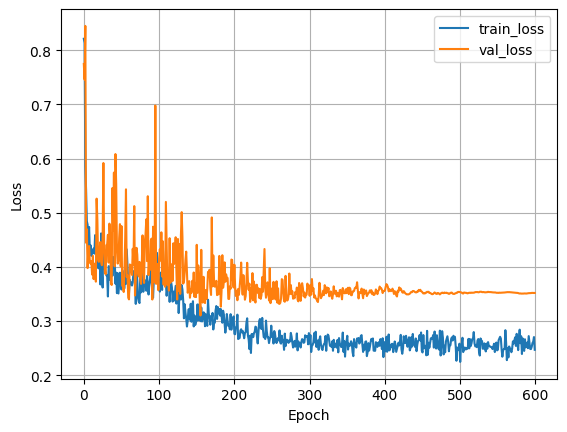

In [44]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [16]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

3/3 [==============================] - 0s 2ms/step
(65, 1)
(65, 1)


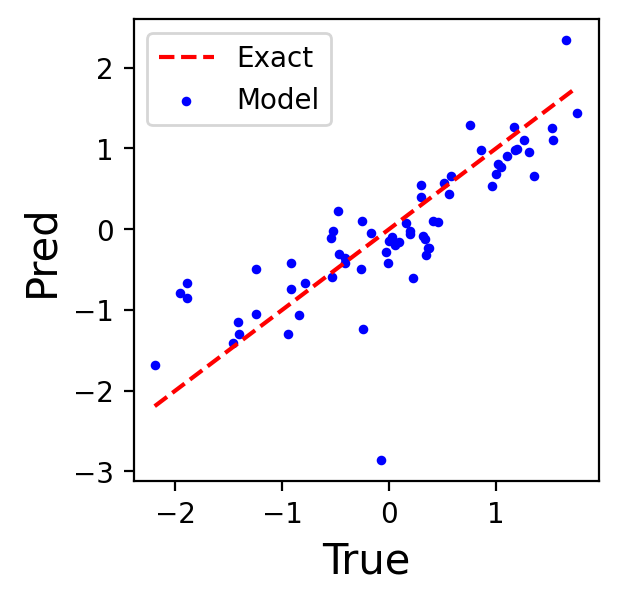

Test MAE: 0.39069810666825855
Test MSE: 0.3171955378677225


In [45]:
# Pred vs True values on test set 

#y_pred = model.predict(x_test)
test_inputs = np.split(x_test,n_pos,axis=1)
y_pred = model.predict(test_inputs)
y_pred.shape
y_true = np.zeros((len(y_test),1))
y_true[:,0] = y_test[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
test_mse = mean_squared_error(y_true,y_pred)

print("Test MAE: "+str(test_mae))
print("Test MSE: "+str(test_mse))

In [18]:
# save model

#reloaded_model = tf.keras.models.load_model('R_model')
model.save('./Models/R_model_invariant_non-linear_many-body_dropout_def_test_simple')

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_non-linear_many-body_dropout_def_test_simple/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_non-linear_many-body_dropout_def_test_simple/assets


9/9 [==============================] - 0s 1ms/step


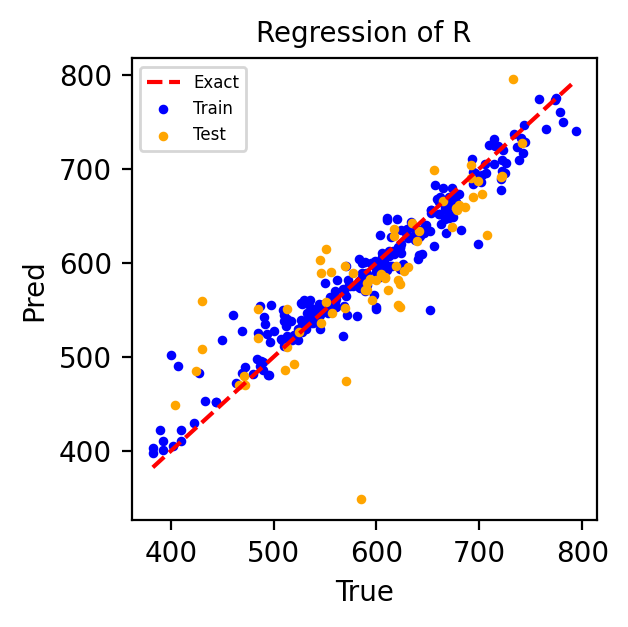

Train MAE (non-normalized): 15.213024413873974
Train RMSE (non-normalized): 22.87521094231774
Train MAPE (non-normalized): 2.70190406554412
Train R2 (non-normalized): 0.9294624646331017

Test MAE (non-normalized): 33.603748513371386
Test RMSE (non-normalized): 48.78784021523142
Test MAPE (non-normalized): 5.927775481572401
Test R2 (non-normalized): 0.6419738689073612


In [36]:
# Evaluate the model with non-normalized units on the whole dataset

#y_pred_test = model.predict(x_test)
y_pred_test = model.predict(test_inputs)
y_true_test = np.zeros((len(y_test),1))
y_true_test[:,0] = y_test[:]

#y_pred_train = model.predict(x_train)
y_pred_train = model.predict(train_inputs)
y_true_train = np.zeros((len(y_train),1))
y_true_train[:,0] = y_train[:]

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("Train MAE (non-normalized): "+str(train_mae))
train_mse = mean_squared_error(y_true_train,y_pred_train,squared=False)
print("Train RMSE (non-normalized): "+str(train_mse))
train_mape = mean_absolute_percentage_error(y_true_train,y_pred_train)*100
print("Train MAPE (non-normalized): "+str(train_mape))
train_r2 = r2_score(y_true_train,y_pred_train)
print("Train R2 (non-normalized): "+str(train_r2))

print()
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("Test MAE (non-normalized): "+str(test_mae))
test_mse = mean_squared_error(y_true_test,y_pred_test,squared=False)
print("Test RMSE (non-normalized): "+str(test_mse))
test_mape = mean_absolute_percentage_error(y_true_test,y_pred_test)*100
print("Test MAPE (non-normalized): "+str(test_mape))
test_r2 = r2_score(y_true_test,y_pred_test)
print("Test R2 (non-normalized): "+str(test_r2))

#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

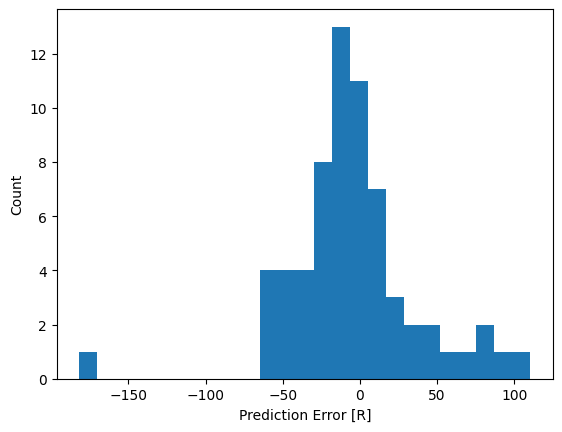

In [28]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


[ 0.  4. 30. 17. 14.]
[        nan 22.54166543 20.61512388 32.0089963  47.44629125]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


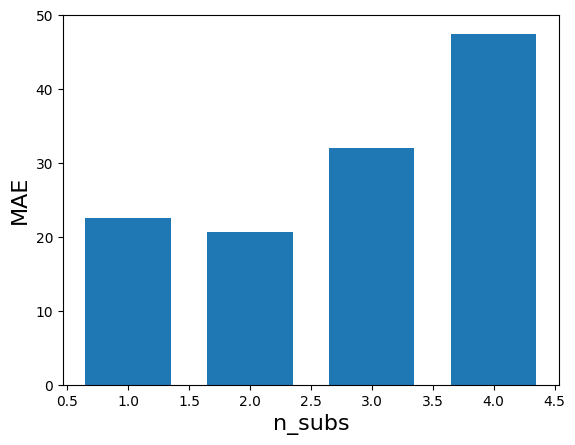

In [29]:
# Error for different nsubs

#x_test = test_features.to_numpy()

nsubs_test = np.zeros( x_test.shape[0] )
#print(x_test[0,:])

# compute number of substitutes for each data test
for i in range(len(nsubs_test)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_test[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_test[i] = nsubs_i
#print(nsubs_test)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
num_subs = np.zeros(5)
for i in range(len(nsubs_test)):
    error_i = y_pred_test[i] - y_true_test[i]
    if(nsubs_test[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_test[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_test[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_test[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_test[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1

error_nsubs = np.zeros(5)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([0,1,2,3,4],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.ylim((0,50))
plt.show()

[  1.  28. 109.  63.  58.]
[ 2.50440459  9.15959639 11.85893214 11.50208078 11.0510033 ]


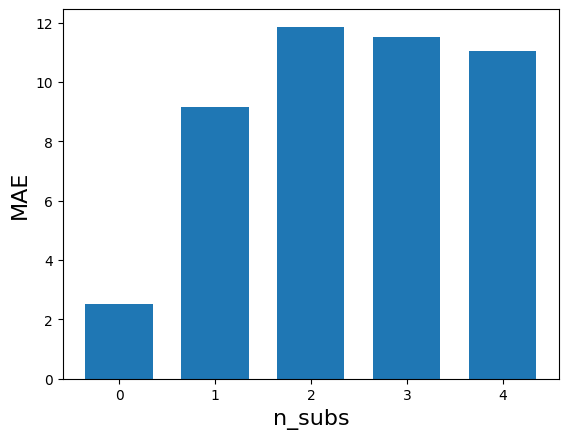

In [30]:
# Error for different nsubs on Training set

nsubs_train = np.zeros( x_train.shape[0] )
#print(x_train[0,:])

# compute number of substitutes for each data train
for i in range(len(nsubs_train)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_train[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_train[i] = nsubs_i
#print(nsubs_train)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
num_subs = np.zeros(5)
for i in range(len(nsubs_train)):
    error_i = y_pred_train[i] - y_true_train[i]
    if(nsubs_train[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_train[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_train[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_train[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_train[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1

error_nsubs = np.zeros(5)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([0,1,2,3,4],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.show()

In [31]:
# Invariance test

x1 = dataset_np[127,0:16]
x1_flip = x1.copy()
x1_flip = np.flip(x1)
#print(x1)
#print(x1_reverse)

# one-hot encode

x1_ohe = np.zeros((1,n_features))
x1_flip_ohe = np.zeros((1,n_features))
for j in range(n_pos):
    #atom_id = int(dataset_np[0,j])
    atom_id = int(x1[j])
    x1_ohe[0,j*n_atom_types+atom_id] = 1.0
    atom_id = int(x1_flip[j])
    x1_flip_ohe[0,j*n_atom_types+atom_id] = 1.0

x1_inputs = np.split(x1_ohe,n_pos,axis=1)
y_pred1 = model.predict(x1_inputs)
print(y_pred1[0])

x1_flip_inputs = np.split(x1_flip_ohe,n_pos,axis=1)
y_pred1_flip = model.predict(x1_flip_inputs)
print(y_pred1_flip[0])


1/1 [==============================] - 0s 26ms/step
[-0.4247598]
1/1 [==============================] - 0s 28ms/step
[-0.4247598]
